In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/My Drive/ann challenge

## Import Libraries


In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print('TensorFlow version:', tf.__version__)
print('Detected GPUs:', tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.14.0
Detected GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
sns.set_theme()

## Auxiliary functions

In [5]:
def plot_images(X, y, num_images=7, start_index=0) -> None:
  plt.figure(figsize=(12, 12))
  for i in range(num_images**2):
      _ = plt.subplot(num_images, num_images, i + 1)
      plt.imshow(X[start_index+i].astype(np.uint8))
      plt.title(f'{y.argmax(axis=1)[start_index+i]}', fontsize=8)
      plt.axis("off")
  plt.show()

In [6]:
def plot_class_distribution(train_labels, val_labels):
  train_labels, val_labels = train_labels.argmax(axis=1), val_labels.argmax(axis=1)
  plt.figure(figsize=(14, 5))
  plt.subplot(1, 2, 1)
  sns.histplot(x=train_labels, hue=train_labels, binwidth=0.5)
  plt.xticks([0, 1], ['healthy', 'unhealthy'])
  plt.title('Training set class distribution')
  plt.xlabel('Class name')
  plt.ylabel('Count')

  plt.subplot(1, 2, 2)
  sns.histplot(x=val_labels, hue=val_labels, binwidth=0.5)
  plt.xticks([0, 1], ['healthy', 'unhealthy'])
  plt.title('Validation set class distribution')
  plt.xlabel('Class name')
  plt.ylabel('Count')
  plt.show()

In [7]:
def plot_history(history, log_scale: bool = False) -> None:
  acc = history['accuracy']
  val_acc = history['val_accuracy']
  loss = history['loss']
  val_loss = history['val_loss']
  best_epoch = np.argmax(val_acc)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.title('Training and validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')

  if log_scale:
      plt.semilogy(loss, label='Training Loss', color='#ff7f0e')
      plt.semilogy(val_loss, label='Validation Loss', color='#4D61E2')
  else:
      plt.plot(loss, label='Training Loss', color='#ff7f0e')
      plt.plot(val_loss, label='Validation Loss', color='#4D61E2')
  plt.plot(best_epoch, history['val_loss'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.grid(True)
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('Training and validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(acc, label='Training Accuracy', color='#ff7f0e')
  plt.plot(val_acc, label='Validation Accuracy', color='#4D61E2')
  plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.grid(True)
  plt.legend()
  plt.show()

In [8]:
def print_report(y_true, y_pred):
  true_labels, pred_labels = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
  print(classification_report(true_labels, pred_labels, target_names=['healthy', 'unhealthy'], digits=4))

In [9]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
  labels = ['healthy', 'unhealthy']
  plt.figure(figsize=(8, 7))
  sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels, square=True, cmap='Blues', annot=True, fmt='.0f')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

## Load data

In [10]:
data = np.load('preprocessed_data255.npz', allow_pickle=True)
X_train, X_val, y_train, y_val = data["X_train"], data["X_val"], data["y_train"], data["y_val"]

In [11]:
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (4003, 96, 96, 3)
Training Label Shape: (4003, 2)
Validation Data Shape: (1001, 96, 96, 3)
Validation Label Shape: (1001, 2)


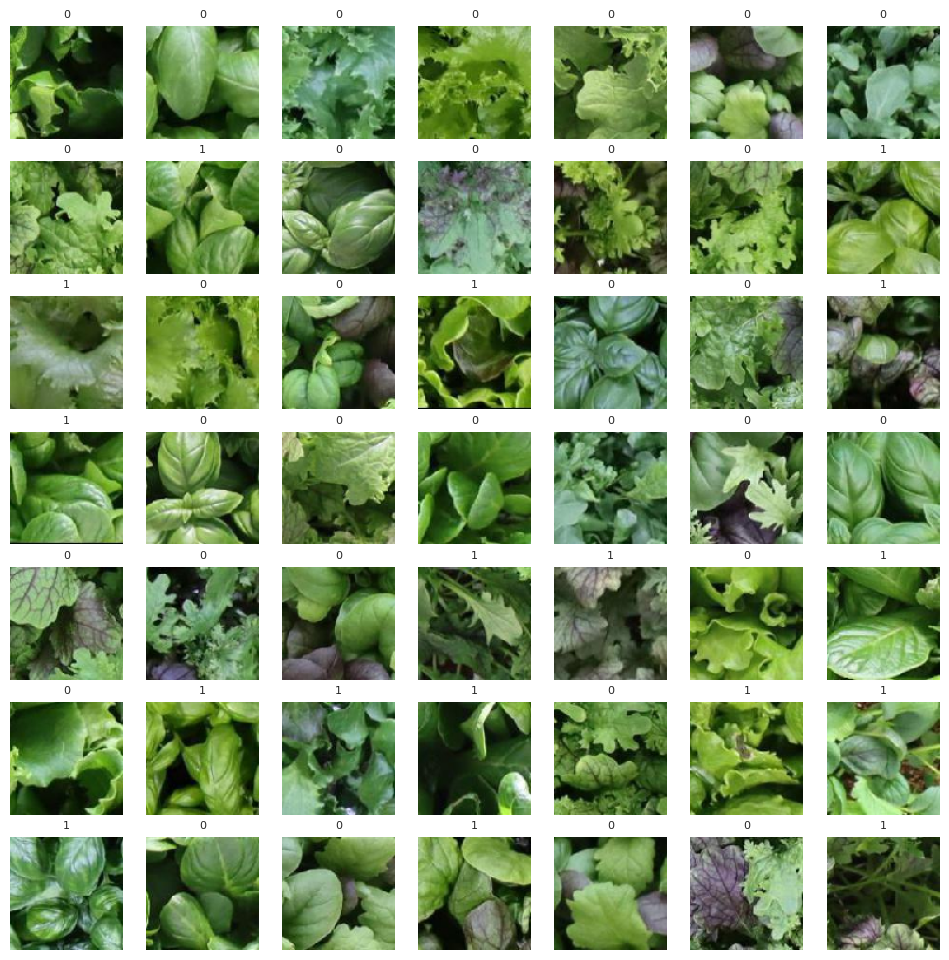

In [12]:
plot_images(X_train, y_train)

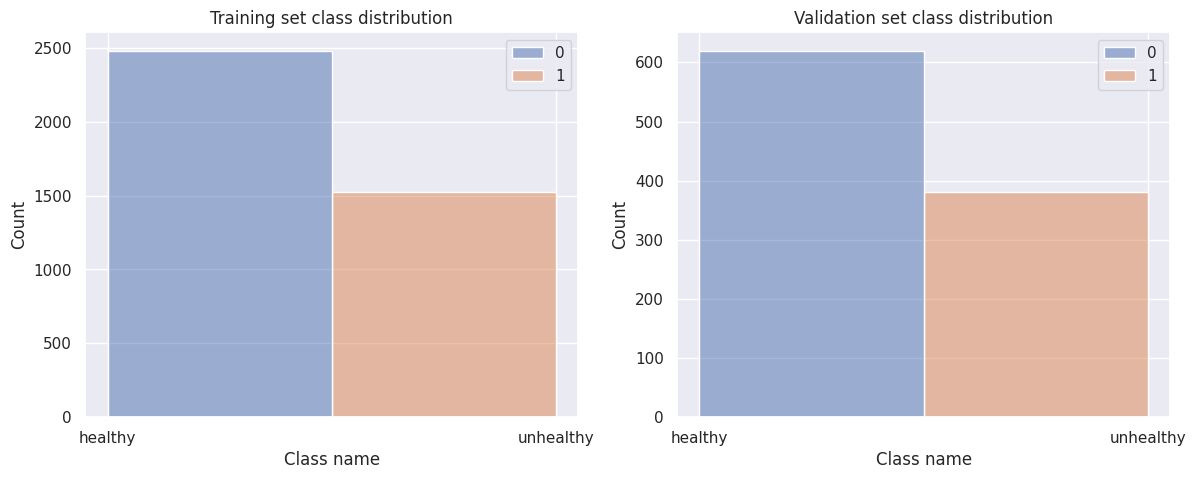

In [13]:
plot_class_distribution(y_train, y_val)

## Build model

In [14]:
# Define key model parameters
input_shape = X_train.shape[1:]         # Input shape for the model
output_shape = len(np.unique(y_train))  # Output shape for the model

# Print the defined parameters
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 2


In [15]:
def build_ensemble(input_shape: tuple[int, int, int], models_list: list[tfk.Model, ...], connection: str, weights: list[float, ...] = None) -> tfk.Model:
    # Define the input
    input_layer = tfkl.Input(shape=input_shape, name='input')

    # Pass the input to the models
    y = [m(input_layer) for m in models_list]

    # Weight the individual contributions of the models
    if weights is not None:
      y = [yi * wi for yi, wi in zip(y, weights)]

    # Connect the outputs of the models
    if connection == 'add':
      output_layer = tfkl.Add()(y)
    elif connection == 'multiply':
      output_layer = tfkl.Multiply()(y)
    elif connection == 'maximum':
      output_layer = tfkl.Maximum()(y)
    else:
      raise ValueError('Connection method not implemented')

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name=f'{connection}-ensemble')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(from_logits=True),
        optimizer=tfk.optimizers.AdamW(learning_rate=1e-3),
        metrics=['accuracy'])

    # Return the model
    return model

In [16]:
models_path = ['efficientnet-v2-b0', 'convnext-base', 'efficientnet-v2-l']

In [17]:
# Instantiate the models that will be used in the ensemble in a list
models = []
for path in models_path:
    m = tfk.models.load_model('ensemble/' + path)
    m._name = path
    m.trainable = False
    models.append(m)
models

In [18]:
accuracies = [m.evaluate(X_val, y_val)[1] for m in models]
weights = [np.log(acc / (1 - acc)) for acc in accuracies]
weights = [wi / sum(weights) for wi in weights]

32/32 [==============================] - 9s 88ms/step - loss: 0.2646 - accuracy: 0.9001


In [19]:
print(accuracies)
print(weights)

[0.8801198601722717, 0.9090909361839294, 0.9000998735427856]
[0.3069628185345659, 0.35454467980945914, 0.3384925016559749]


## Add Ensemble (with weights)

In [20]:
model = build_ensemble(input_shape, models, connection='add', weights=weights)
model.summary()

Model: "add-ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 efficientnet-v2-b0 (Functi  (None, 2)                    7499090   ['input[0][0]']               
 onal)                                                                                            
                                                                                                  
 convnext-base (Functional)  (None, 2)                    8888409   ['input[0][0]']               
                                                          8                                       
                                                                                       

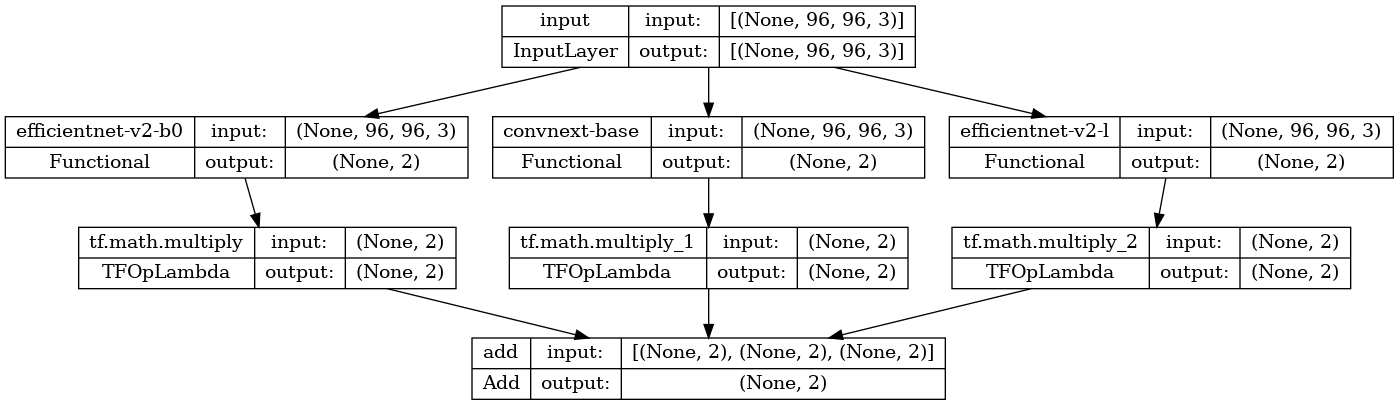

In [21]:
tfk.utils.plot_model(model, show_shapes=True)

In [22]:
y_pred = model.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1)):.4f}")

32/32 [==============================] - 20s 195ms/step
Accuracy: 0.9151


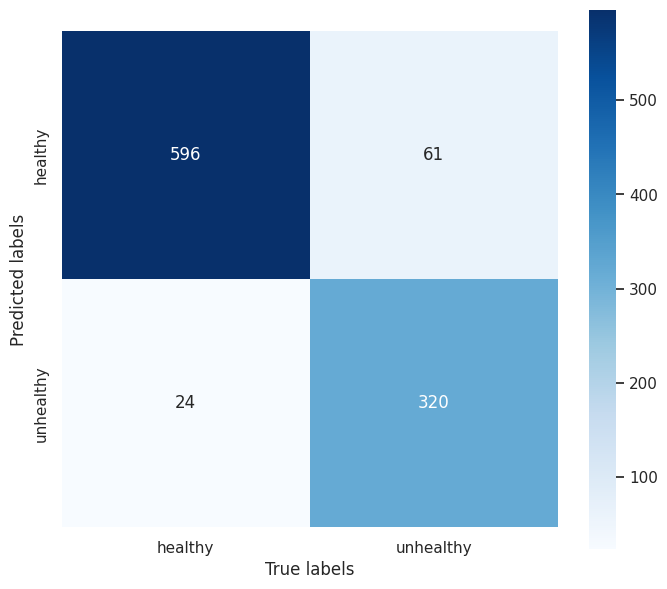

In [23]:
plot_confusion_matrix(y_val, y_pred)

In [24]:
print_report(y_val, y_pred)

              precision    recall  f1-score   support

     healthy     0.9072    0.9613    0.9334       620
   unhealthy     0.9302    0.8399    0.8828       381

    accuracy                         0.9151      1001
   macro avg     0.9187    0.9006    0.9081      1001
weighted avg     0.9159    0.9151    0.9141      1001


In [25]:
# Save the model
model.save('ensemble/combined/' + model.name)
del model

## Add Ensemble (no weights)

In [27]:
model = build_ensemble(input_shape, models, connection='add', weights=None)
model.summary()

Model: "add-ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 efficientnet-v2-b0 (Functi  (None, 2)                    7499090   ['input[0][0]']               
 onal)                                                                                            
                                                                                                  
 convnext-base (Functional)  (None, 2)                    8888409   ['input[0][0]']               
                                                          8                                       
                                                                                       

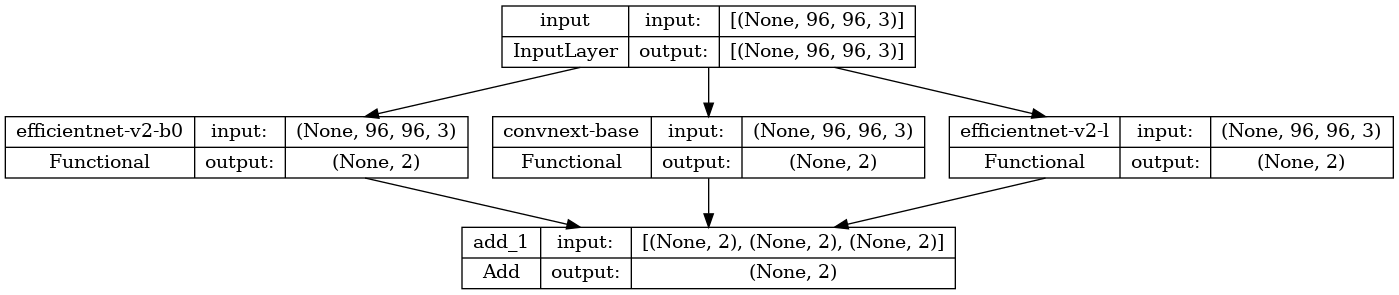

In [28]:
tfk.utils.plot_model(model, show_shapes=True)

In [29]:
y_pred = model.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1)):.4f}")

32/32 [==============================] - 23s 202ms/step
Accuracy: 0.9151


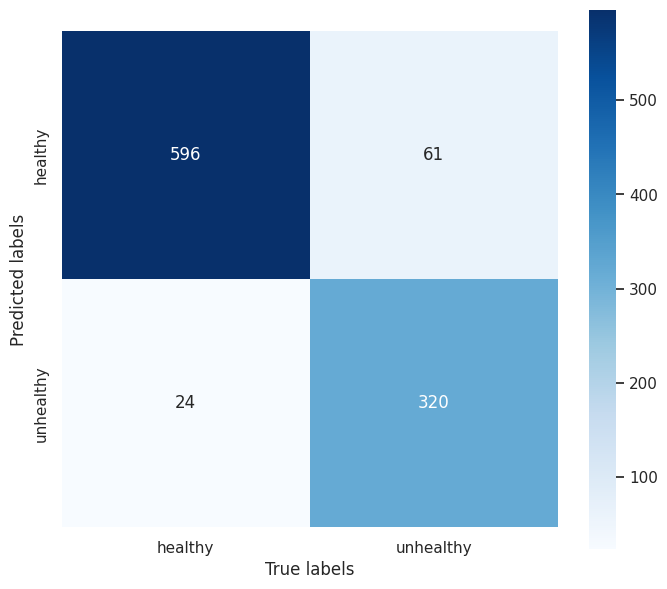

In [30]:
plot_confusion_matrix(y_val, y_pred)

In [31]:
print_report(y_val, y_pred)

              precision    recall  f1-score   support

     healthy     0.9072    0.9613    0.9334       620
   unhealthy     0.9302    0.8399    0.8828       381

    accuracy                         0.9151      1001
   macro avg     0.9187    0.9006    0.9081      1001
weighted avg     0.9159    0.9151    0.9141      1001


In [32]:
# Save the model
model.save('ensemble/combined/' + model.name + '-no-weights')
del model

## Multiply Ensemble

In [33]:
model = build_ensemble(input_shape, models, connection='multiply', weights=weights)
model.summary()

Model: "multiply-ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 efficientnet-v2-b0 (Functi  (None, 2)                    7499090   ['input[0][0]']               
 onal)                                                                                            
                                                                                                  
 convnext-base (Functional)  (None, 2)                    8888409   ['input[0][0]']               
                                                          8                                       
                                                                                  

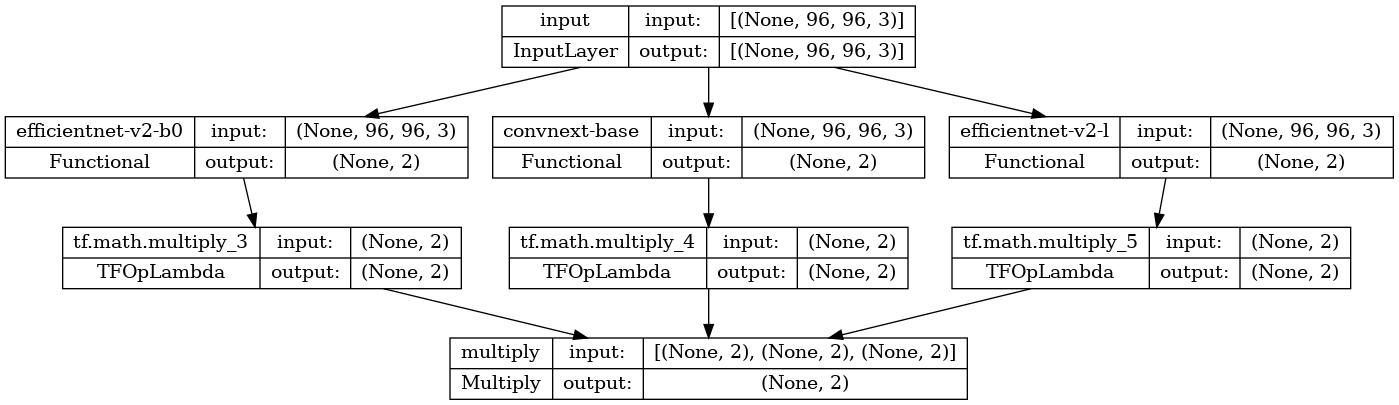

In [34]:
tfk.utils.plot_model(model, show_shapes=True)

In [35]:
y_pred = model.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1)):.4f}")

32/32 [==============================] - 20s 175ms/step
Accuracy: 0.8422


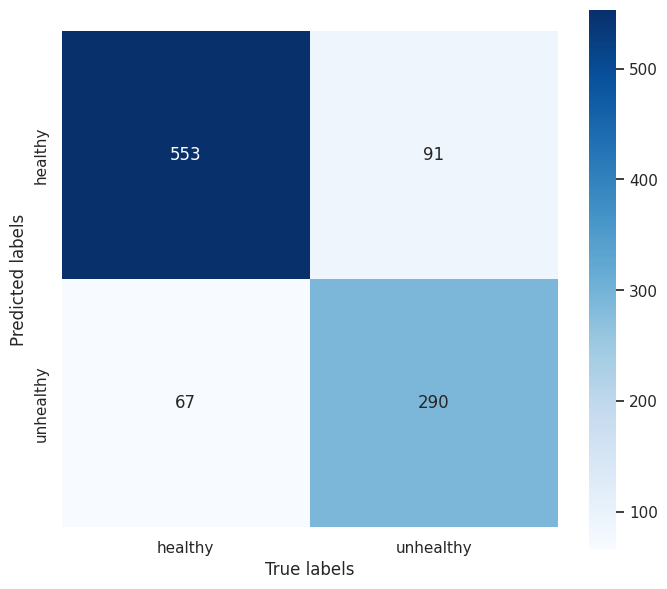

In [36]:
plot_confusion_matrix(y_val, y_pred)

In [37]:
print_report(y_val, y_pred)

              precision    recall  f1-score   support

     healthy     0.8587    0.8919    0.8750       620
   unhealthy     0.8123    0.7612    0.7859       381

    accuracy                         0.8422      1001
   macro avg     0.8355    0.8265    0.8305      1001
weighted avg     0.8410    0.8422    0.8411      1001


In [38]:
# Save the model
# model.save('ensemble/combined/' + model.name)
del model

## Maximum Ensemble (with weights)

In [39]:
model = build_ensemble(input_shape, models, connection='maximum', weights=weights)
model.summary()

Model: "maximum-ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 efficientnet-v2-b0 (Functi  (None, 2)                    7499090   ['input[0][0]']               
 onal)                                                                                            
                                                                                                  
 convnext-base (Functional)  (None, 2)                    8888409   ['input[0][0]']               
                                                          8                                       
                                                                                   

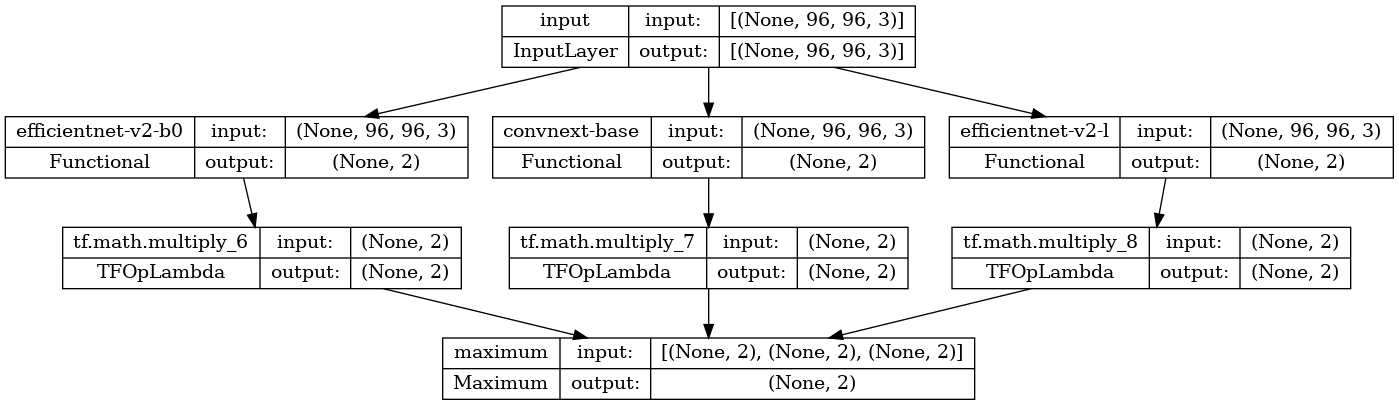

In [40]:
tfk.utils.plot_model(model, show_shapes=True)

In [42]:
y_pred = model.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1)):.4f}")

32/32 [==============================] - 5s 159ms/step
Accuracy: 0.9031


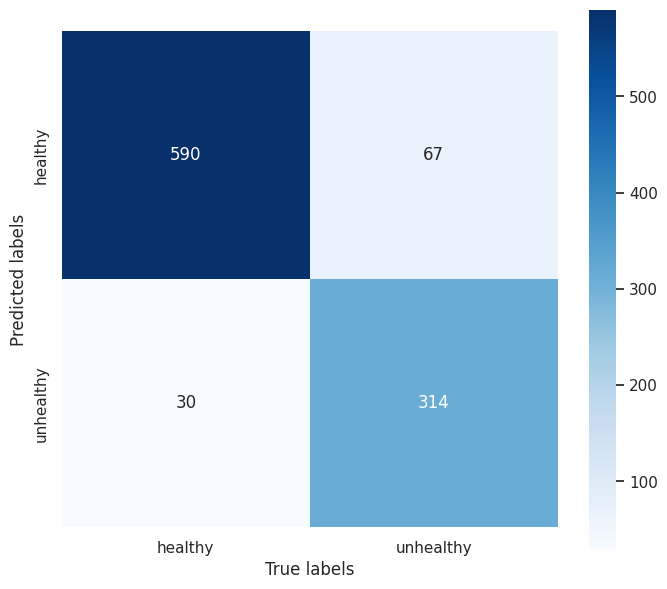

In [43]:
plot_confusion_matrix(y_val, y_pred)

In [44]:
print_report(y_val, y_pred)

              precision    recall  f1-score   support

     healthy     0.8980    0.9516    0.9240       620
   unhealthy     0.9128    0.8241    0.8662       381

    accuracy                         0.9031      1001
   macro avg     0.9054    0.8879    0.8951      1001
weighted avg     0.9036    0.9031    0.9020      1001


In [45]:
# Save the model
model.save('ensemble/combined' + model.name)
del model

## Maximum Ensemble (no weights)

In [46]:
model = build_ensemble(input_shape, models, connection='maximum', weights=None)
model.summary()

Model: "maximum-ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 efficientnet-v2-b0 (Functi  (None, 2)                    7499090   ['input[0][0]']               
 onal)                                                                                            
                                                                                                  
 convnext-base (Functional)  (None, 2)                    8888409   ['input[0][0]']               
                                                          8                                       
                                                                                   

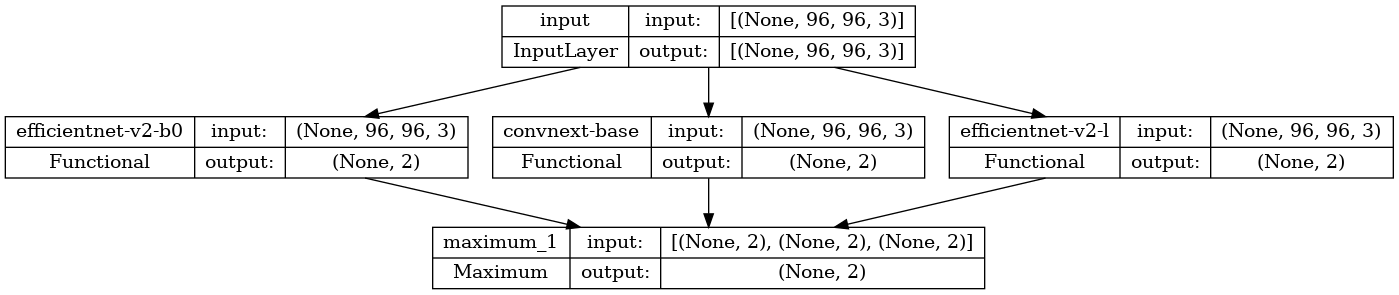

In [47]:
tfk.utils.plot_model(model, show_shapes=True)

In [48]:
y_pred = model.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1)):.4f}")

32/32 [==============================] - 20s 177ms/step
Accuracy: 0.9021


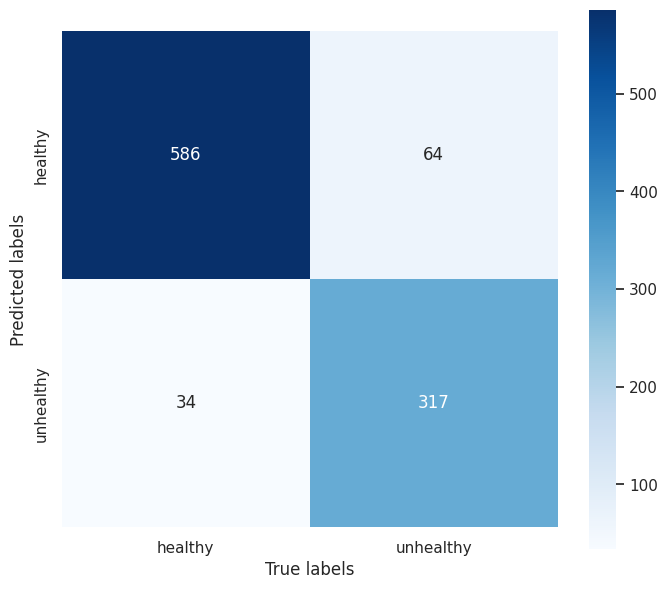

In [49]:
plot_confusion_matrix(y_val, y_pred)

In [50]:
print_report(y_val, y_pred)

              precision    recall  f1-score   support

     healthy     0.9015    0.9452    0.9228       620
   unhealthy     0.9031    0.8320    0.8661       381

    accuracy                         0.9021      1001
   macro avg     0.9023    0.8886    0.8945      1001
weighted avg     0.9021    0.9021    0.9012      1001


In [51]:
# Save the model
model.save('ensemble/combined' + model.name + '-no-weights')
del model

## Stacking Ensemble

In [75]:
def build_stacking_ensemble(input_shape: tuple[int, int, int], models_list: list[tfk.Model, ...]) -> tfk.Model:
    # Define the input
    input_layer = tfkl.Input(shape=input_shape, name='input')

    # Pass the input to the models
    y = [m(input_layer) for m in models_list]
    y = tf.concat(y, axis=1)

    # Perform a linear combination of the outputs of the models
    output_layer = tfkl.Dense(2, use_bias=True, activation=None, name='connection')(y)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='stacking-ensemble')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(from_logits=True),
        optimizer=tfk.optimizers.AdamW(learning_rate=1e-4),
        metrics=['accuracy'])

    # Return the model
    return model

In [76]:
model = build_stacking_ensemble(input_shape, models)
model.summary()

Model: "stacking-ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 efficientnet-v2-b0 (Functi  (None, 2)                    7499090   ['input[0][0]']               
 onal)                                                                                            
                                                                                                  
 convnext-base (Functional)  (None, 2)                    8888409   ['input[0][0]']               
                                                          8                                       
                                                                                  

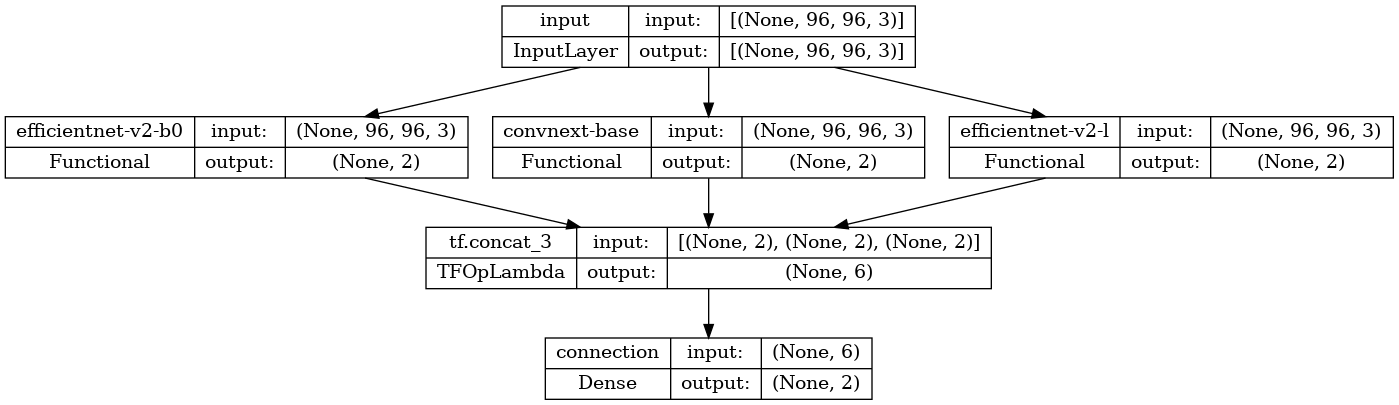

In [77]:
tfk.utils.plot_model(model, show_shapes=True)

In [78]:
lr_patience = 5
es_patience = 15
callbacks = [
    tfk.callbacks.TerminateOnNaN(),
    tfk.callbacks.ReduceLROnPlateau('val_accuracy', patience=lr_patience, factor=0.3, min_lr=1e-7, verbose=1),
    tfk.callbacks.EarlyStopping('val_accuracy', patience=es_patience, restore_best_weights=True, verbose=1)
]

In [79]:
# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

Epoch 1/200
126/126 [==============================] - 96s 284ms/step - loss: 4.1223 - accuracy: 0.0972 - val_loss: 4.1278 - val_accuracy: 0.1209 - lr: 1.0000e-04
Epoch 2/200
126/126 [==============================] - 28s 221ms/step - loss: 3.8271 - accuracy: 0.1054 - val_loss: 3.8219 - val_accuracy: 0.1289 - lr: 1.0000e-04
Epoch 3/200
126/126 [==============================] - 28s 221ms/step - loss: 3.4916 - accuracy: 0.1242 - val_loss: 3.5233 - val_accuracy: 0.1389 - lr: 1.0000e-04
Epoch 4/200
126/126 [==============================] - 29s 230ms/step - loss: 3.3164 - accuracy: 0.1381 - val_loss: 3.2305 - val_accuracy: 0.1459 - lr: 1.0000e-04
Epoch 5/200
126/126 [==============================] - 29s 228ms/step - loss: 3.0444 - accuracy: 0.1549 - val_loss: 2.9530 - val_accuracy: 0.1608 - lr: 1.0000e-04
Epoch 6/200
126/126 [==============================] - 28s 224ms/step - loss: 2.8717 - accuracy: 0.1766 - val_loss: 2.6846 - val_accuracy: 0.1848 - lr: 1.0000e-04
Epoch 7/200
126/126 [=

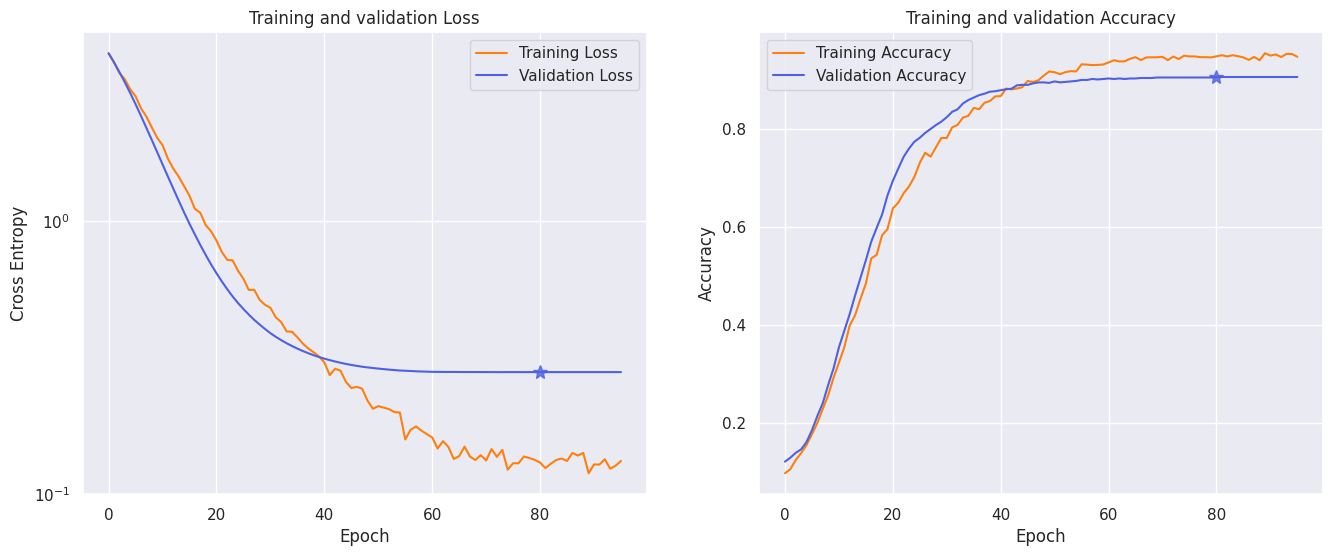

In [80]:
plot_history(history, log_scale=True)

In [81]:
model.layers[-1].weights

[<tf.Variable 'connection/kernel:0' shape=(6, 2) dtype=float32, numpy=
 array([[ 0.32796982, -0.89969397],
        [ 0.27882242,  0.04843429],
        [-0.41604587, -0.5995444 ],
        [-0.43745193,  1.0886353 ],
        [ 0.48974591,  0.03728592],
        [ 0.02190236, -0.2926116 ]], dtype=float32)>,
 <tf.Variable 'connection/bias:0' shape=(2,) dtype=float32, numpy=array([ 0.29265845, -0.29265854], dtype=float32)>]

In [82]:
y_pred = model.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1)):.4f}")

32/32 [==============================] - 29s 230ms/step
Accuracy: 0.9051


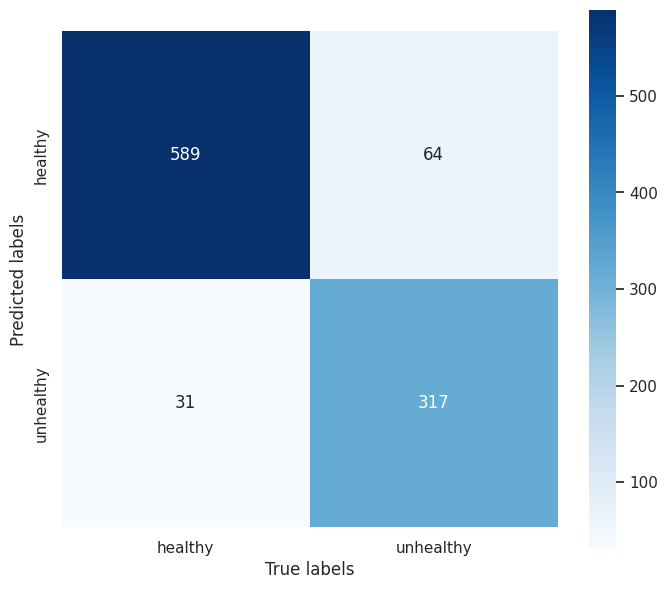

In [83]:
plot_confusion_matrix(y_val, y_pred)

In [84]:
print_report(y_val, y_pred)

              precision    recall  f1-score   support

     healthy     0.9020    0.9500    0.9254       620
   unhealthy     0.9109    0.8320    0.8697       381

    accuracy                         0.9051      1001
   macro avg     0.9065    0.8910    0.8975      1001
weighted avg     0.9054    0.9051    0.9042      1001


In [85]:
# Save the model
model.save('ensemble/combined' + model.name)
del model